<table style="float:left; border:none">
   <tr style="border:none">
       <td style="border:none">  
           <img 
               src="../images/EmpleaFidelidad.png" 
               style="width:200px"
           >
           </a>    
       </td>
   </tr>
</table>
<div style="float:right;font-size: 20px;"><h2>IBM - 09 - Evaluation Models</h2></div>

<a id="top"></a> <br>
## Índice
1. [Carga de paquetes y datos](#1)<br>
    1.1. [Librerías y clases](#11)<br>
    1.2. [Lectura de datos](#12)<br>
    1.3. [Importación de modelos Shelve](#13)<br>
    1.4. [Separación en train y test](#14)<br>    
2. [Evaluación de Modelos](#2)<br>
    2.1. [Lectura de modelo y metricas en shelve](#21)<br>
    2.2. [ Métricas](#22)<br>
    2.3. [Matriz de confusión](#23)<br>
    2.4. [ROC Curve](#24)<br>
    2.5. [Precision-Recall Curve](#25)<br>
3. [Conclusiones y elección de modelo](#3)<br>
    3.1. [Conclusiones y elección de modelo](#31)<br>
4. [Predicción con mejor modelo](#4)<br>
    4.1. [Prediccion con mejor modelo](#41)<br>
    4.2. [Exportar predicciones en CSV](#42)<br>

***
<a id="1"></a> <br>
## 1. Carga de paquetes y datos

<a id="11"></a>
### 1.1. Librerías y clases

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib. pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, fbeta_score, confusion_matrix, accuracy_score, roc_auc_score, recall_score, fbeta_score, make_scorer, f1_score, roc_curve, precision_score, precision_recall_curve, plot_precision_recall_curve, average_precision_score
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler,  FunctionTransformer, LabelEncoder, binarize
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import make_pipeline, make_union
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn import tree
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline 
from catboost import CatBoostClassifier

from IPython.display import Image
import pydotplus

import shelve

import warnings
warnings.filterwarnings("ignore")

C:\Users\gtoso\anaconda3\envs\dhproyect\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Esta clase permite dropear columnas de un DataFrame dentro de un pipeline

class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self,columns):
        self.columns=columns

    def transform(self,X,y=None):
        return X.drop(self.columns,axis=1)

    def fit(self, X, y=None):
        return self  

<a id="12"></a>
### 1.2. Lecura de datos

In [3]:
# Carga de dataset
key= "ibm.clean.Education.csv"
path="../Data/"
df = pd.read_csv(path + key)
df.sample(3)

,EmployeeID,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Employee Source,AgeStartedWorking
2761,8344,39,0,Non-Travel,Research & Development,12,Bachelor,Medical,4,Male,...,0,7,6,3,1,0,0,0,Recruit.net,32
2474,7683,40,0,Travel_Rarely,Research & Development,14,Bachelor,Medical,4,Male,...,2,1,2,2,1,0,0,0,Company Website,39
1853,5184,37,0,Travel_Rarely,Sales,9,College,Marketing,3,Male,...,1,8,3,2,7,7,7,5,GlassDoor,29


<a id="13"></a>
### 1.3. Importación de modelos Shelve

In [4]:
# Lectura de datos binarizados de modelos y thresholds con shelve
gaussian = shelve.open('../Models Shelve/02.Gaussian_Naive_Bayes.db')
rforest = shelve.open('../Models Shelve/03.RandomForest.db')
SMOTE_rforest = shelve.open('../Models Shelve/04.SMOTE_RandomForest.db')
ENN_rforest = shelve.open('../Models Shelve/05.ENN_RandomForest.db')
lgbm = shelve.open('../Models Shelve/06.lgbm.db')
SMOTE_lgbm = shelve.open('../Models Shelve/07.SMOTElgbm.db')
dtree = shelve.open('../Models Shelve/08.DecissionTree.db')

<a id="14"></a>
### 1.4. Separación en train y test

In [5]:
# Separacion en train y test
# Selección de variable targuet
y = df.Attrition
# Selección de features
X = df.drop(["Attrition"], axis = 1)

# Separación en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 161, stratify= y)

# Verificación de distribución de variable targuet en train y test
print("Distribución de variable target en Train \n", y_train.value_counts(normalize=True))
print("========================================")
print("Distribución de variable target en Test \n", y_test.value_counts(normalize=True))

Distribución de variable target en Train 
 0    0.842728
1    0.157272
Name: Attrition, dtype: float64
Distribución de variable target en Test 
 0    0.84279
1    0.15721
Name: Attrition, dtype: float64


***
<a id="2"></a> <br>
## 2. Evaluación de modelos

<a id="21"></a> <br>
### 2.1. Lectura de modelo y metricas en shelve

In [6]:
gaussian_model = gaussian["modelo"]
gaussian_metricas = gaussian["metricas"]

rforest_model = rforest["modelo"]
rforest_metricas = rforest["metricas"]

SMOTE_rforest_model = SMOTE_rforest["modelo"]
SMOTE_rforest_metricas = SMOTE_rforest["metricas"]

ENN_rforest_model = ENN_rforest["modelo"]
ENN_rforest_metricas = ENN_rforest["metricas"]

lgbm_model = lgbm["modelo"]
lgbm_metricas = lgbm["metricas"]

SMOTE_lgbm_model = SMOTE_lgbm["modelo"]
SMOTE_lgbm_metricas = SMOTE_lgbm["metricas"]

dtree_model = dtree["modelo"]
dtree_metricas = dtree["metricas"]

<a id="22"></a> <br>
### 2.2. Métricas

In [7]:
# Concatenación de dataframes con métricas de modelos
metricas = pd.concat([gaussian_metricas,rforest_metricas,SMOTE_rforest_metricas,ENN_rforest_metricas,lgbm_metricas,SMOTE_lgbm_metricas,dtree_metricas], axis = 0)
metricas

,Models,F2 Score Train,F2 Score Test,F1 Score Train,F1 Score Test,Accuracy Score Train,Accuracy Score Test,ROC AUC Score Train,ROC AUC Score Test,Recall Score Train,Recall Score Test,Precision Score Train,Precision Score Test
0,Gaussian Naive Bayes,0.416856,0.383543,0.366733,0.345912,0.750887,0.754137,0.632036,0.615603,0.458647,0.413534,0.305509,0.297297
0,Random Forest,0.945122,0.135624,0.964981,0.194805,0.989358,0.853428,0.966165,0.552183,0.932331,0.112782,1.000000,0.714286
0,SMOTE Random Forest,1.000000,0.126582,1.000000,0.181818,1.000000,0.851064,1.000000,0.547723,1.000000,0.105263,1.000000,0.666667
0,ENN Random Forest,0.690789,0.488445,0.471910,0.336347,0.648009,0.566194,0.791160,0.620311,1.000000,0.699248,0.308824,0.221429
0,lgbm,0.718143,0.486486,0.504744,0.342205,0.691368,0.591017,0.816885,0.625863,1.000000,0.676692,0.337563,0.229008
0,SMOTElgbm,0.327869,0.237691,0.405594,0.294737,0.865983,0.841608,0.632033,0.584927,0.290727,0.210526,0.670520,0.491228
0,Decission Tree Classifier,0.391181,0.365169,0.361842,0.332268,0.770595,0.752955,0.625382,0.605727,0.413534,0.390977,0.321637,0.288889


<a id="23"></a> <br>
### 2.3. Matriz de confusión

In [8]:
model_pred_test_gaussian = gaussian_model.predict(X_test)

model_pred_test_rforest = rforest_model.predict(X_test)

model_pred_test_SMOTE_rforest = SMOTE_rforest_model.predict(X_test)

model_pred_test_ENN_rforest = ENN_rforest_model.predict(X_test)

model_pred_test_lgbm = lgbm_model.predict(X_test)

model_pred_test_SMOTE_lgbm = SMOTE_lgbm_model.predict(X_test)

model_pred_test_dtree = dtree_model.predict(X_test)

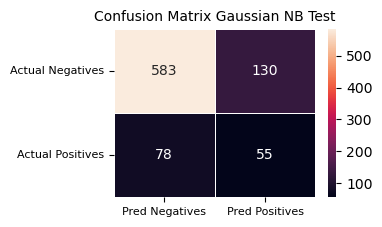

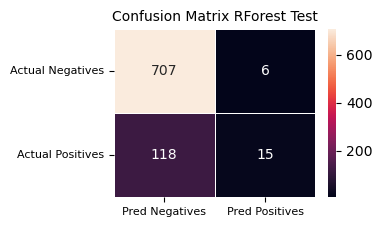

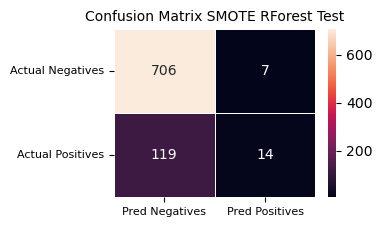

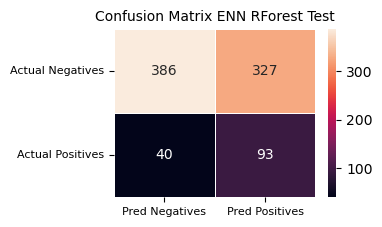

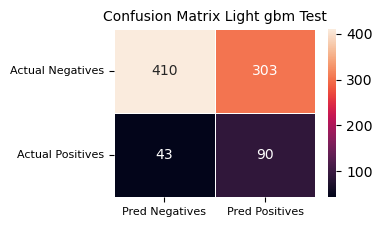

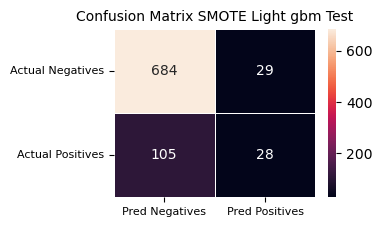

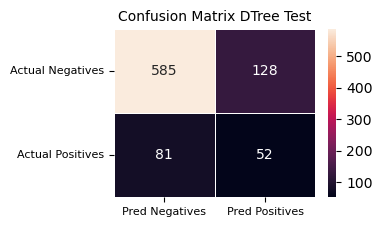

In [9]:
# Matriz de confusion gaussian NB
conf_matrix = confusion_matrix(y_test, model_pred_test_gaussian)
f, ax = plt.subplots(figsize=(3, 2))
sns.heatmap(conf_matrix, annot=True, fmt="d", linewidths=.6, ax=ax)
plt.title("Confusion Matrix Gaussian NB Test", fontsize=10)
plt.subplots_adjust(left=0.15, right=0.99, bottom=0.15, top=0.99)
ax.set_yticks(np.arange(conf_matrix.shape[0]) + 0.5, minor=False)
ax.set_xticklabels(['Pred Negatives', 'Pred Positives'],fontsize=8, rotation=360)
ax.set_yticklabels(['Actual Negatives', 'Actual Positives'], fontsize=8, rotation=360)
plt.show()
# Matriz de confusion Random Forest
conf_matrix = confusion_matrix(y_test, model_pred_test_rforest)
f, ax = plt.subplots(figsize=(3, 2))
sns.heatmap(conf_matrix, annot=True, fmt="d", linewidths=.6, ax=ax)
plt.title("Confusion Matrix RForest Test", fontsize=10)
plt.subplots_adjust(left=0.15, right=0.99, bottom=0.15, top=0.99)
ax.set_yticks(np.arange(conf_matrix.shape[0]) + 0.5, minor=False)
ax.set_xticklabels(['Pred Negatives', 'Pred Positives'],fontsize=8, rotation=360)
ax.set_yticklabels(['Actual Negatives', 'Actual Positives'], fontsize=8, rotation=360)
plt.show()
# Matriz de confusion SMOTE Random Forest
conf_matrix = confusion_matrix(y_test, model_pred_test_SMOTE_rforest)
f, ax = plt.subplots(figsize=(3, 2))
sns.heatmap(conf_matrix, annot=True, fmt="d", linewidths=.6, ax=ax)
plt.title("Confusion Matrix SMOTE RForest Test", fontsize=10)
plt.subplots_adjust(left=0.15, right=0.99, bottom=0.15, top=0.99)
ax.set_yticks(np.arange(conf_matrix.shape[0]) + 0.5, minor=False)
ax.set_xticklabels(['Pred Negatives', 'Pred Positives'],fontsize=8, rotation=360)
ax.set_yticklabels(['Actual Negatives', 'Actual Positives'], fontsize=8, rotation=360)
plt.show()
# Matriz de confusion ENN random forest
conf_matrix = confusion_matrix(y_test, model_pred_test_ENN_rforest)
f, ax = plt.subplots(figsize=(3, 2))
sns.heatmap(conf_matrix, annot=True, fmt="d", linewidths=.6, ax=ax)
plt.title("Confusion Matrix ENN RForest Test", fontsize=10)
plt.subplots_adjust(left=0.15, right=0.99, bottom=0.15, top=0.99)
ax.set_yticks(np.arange(conf_matrix.shape[0]) + 0.5, minor=False)
ax.set_xticklabels(['Pred Negatives', 'Pred Positives'],fontsize=8, rotation=360)
ax.set_yticklabels(['Actual Negatives', 'Actual Positives'], fontsize=8, rotation=360)
plt.show()
# Matriz de confusion light gbm
conf_matrix = confusion_matrix(y_test, model_pred_test_lgbm)
f, ax = plt.subplots(figsize=(3, 2))
sns.heatmap(conf_matrix, annot=True, fmt="d", linewidths=.6, ax=ax)
plt.title("Confusion Matrix Light gbm Test", fontsize=10)
plt.subplots_adjust(left=0.15, right=0.99, bottom=0.15, top=0.99)
ax.set_yticks(np.arange(conf_matrix.shape[0]) + 0.5, minor=False)
ax.set_xticklabels(['Pred Negatives', 'Pred Positives'],fontsize=8, rotation=360)
ax.set_yticklabels(['Actual Negatives', 'Actual Positives'], fontsize=8, rotation=360)
plt.show()
# Matriz de confusion SMOTE light gbm
conf_matrix = confusion_matrix(y_test, model_pred_test_SMOTE_lgbm)
f, ax = plt.subplots(figsize=(3, 2))
sns.heatmap(conf_matrix, annot=True, fmt="d", linewidths=.6, ax=ax)
plt.title("Confusion Matrix SMOTE Light gbm Test", fontsize=10)
plt.subplots_adjust(left=0.15, right=0.99, bottom=0.15, top=0.99)
ax.set_yticks(np.arange(conf_matrix.shape[0]) + 0.5, minor=False)
ax.set_xticklabels(['Pred Negatives', 'Pred Positives'],fontsize=8, rotation=360)
ax.set_yticklabels(['Actual Negatives', 'Actual Positives'], fontsize=8, rotation=360)
plt.show()
# Matriz de confusion Dtree
conf_matrix = confusion_matrix(y_test, model_pred_test_dtree)
f, ax = plt.subplots(figsize=(3, 2))
sns.heatmap(conf_matrix, annot=True, fmt="d", linewidths=.6, ax=ax)
plt.title("Confusion Matrix DTree Test", fontsize=10)
plt.subplots_adjust(left=0.15, right=0.99, bottom=0.15, top=0.99)
ax.set_yticks(np.arange(conf_matrix.shape[0]) + 0.5, minor=False)
ax.set_xticklabels(['Pred Negatives', 'Pred Positives'],fontsize=8, rotation=360)
ax.set_yticklabels(['Actual Negatives', 'Actual Positives'], fontsize=8, rotation=360)
plt.show()

<a id="24"></a> <br>
### 2.4. ROC Curve

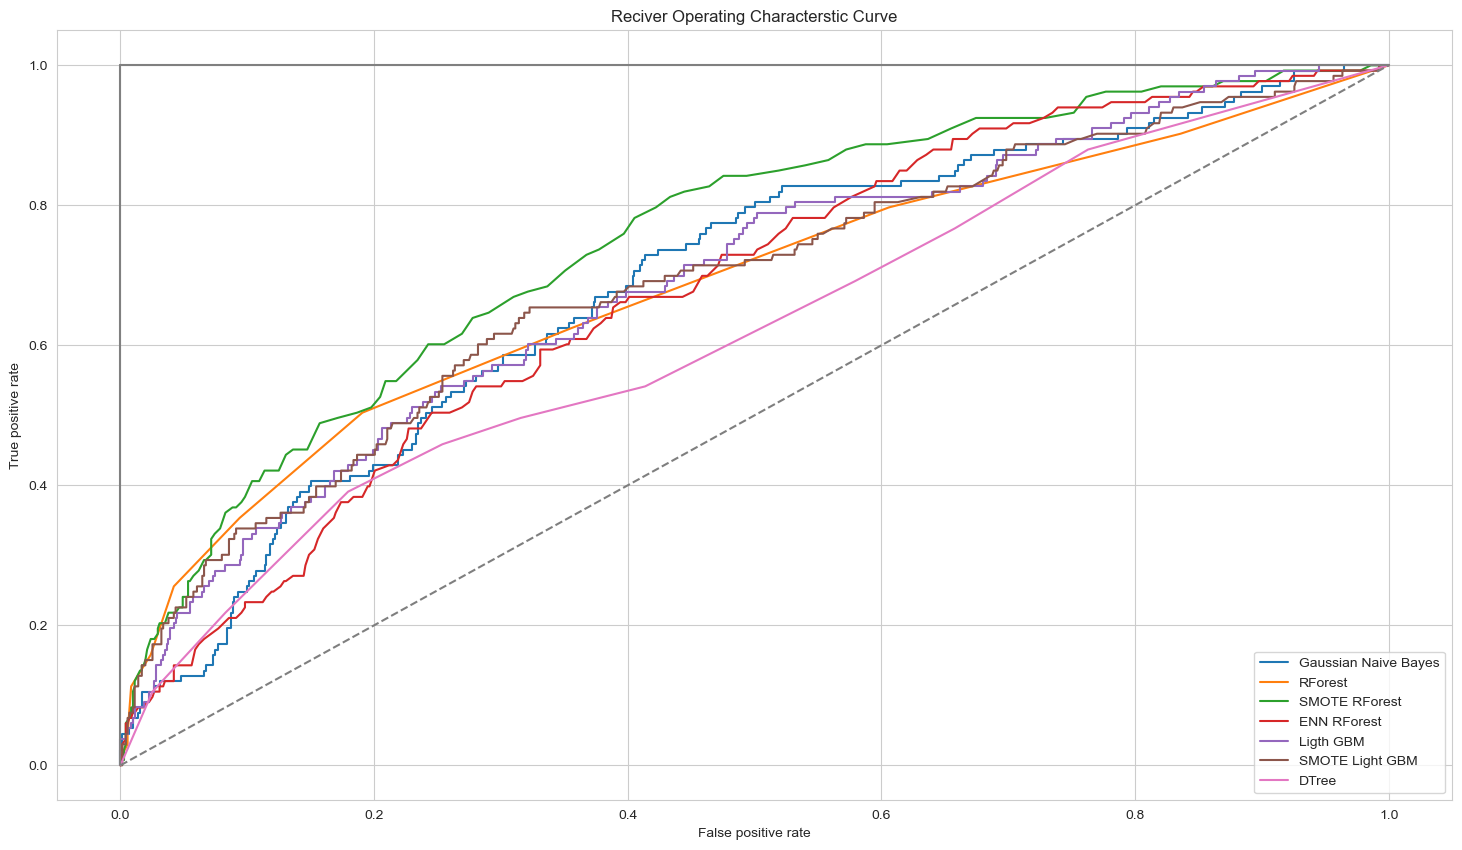

In [10]:
# Obtención de probabilidades de test
probsdmodel_gau = gaussian_model.predict_proba(X_test)
predsdmodel_gau = probsdmodel_gau[:,1]

probsdmodel_rforest = rforest_model.predict_proba(X_test)
predsdmodel_rforest = probsdmodel_rforest[:,1]

probsdmodel_Srforest = SMOTE_rforest_model.predict_proba(X_test)
predsdmodel_Srforest = probsdmodel_Srforest[:,1]

probsdmodel_ENNrforest = ENN_rforest_model.predict_proba(X_test)
predsdmodel_ENNrforest = probsdmodel_ENNrforest[:,1]

probsdmodel_lgbm = lgbm_model.predict_proba(X_test)
predsdmodel_lgbm = probsdmodel_lgbm[:,1]

probsdmodel_SMOTElgbm = SMOTE_lgbm_model.predict_proba(X_test)
predsdmodel_SMOTElgbm = probsdmodel_SMOTElgbm[:,1]

probsdmodel_dtree = dtree_model.predict_proba(X_test)
predsdmodel_dtree = probsdmodel_dtree[:,1]



# Generación de ROC curve
GNB_false_positive_rate , GNB_true_positive_rate , GNB_threshold = roc_curve(y_test ,predsdmodel_gau)
rforest_false_positive_rate , rforest_true_positive_rate , rforest_threshold = roc_curve(y_test , predsdmodel_rforest)
SMOTErforest_false_positive_rate , SMOTErforest_true_positive_rate , SMOTErforest_threshold = roc_curve(y_test , predsdmodel_Srforest )
ENNrforest_false_positive_rate , ENNrforest_true_positive_rate , ENNrforest_threshold = roc_curve(y_test , predsdmodel_ENNrforest)
lgbm_false_positive_rate , lgbm_true_positive_rate , lgbm_threshold = roc_curve(y_test , predsdmodel_lgbm)
Slgbm_false_positive_rate , Slgbm_true_positive_rate , Slgbm_threshold = roc_curve(y_test , predsdmodel_SMOTElgbm)
dtree_false_positive_rate , dtree_true_positive_rate , dtree_threshold = roc_curve(y_test , predsdmodel_dtree)


# Gráfico curva ROC
sns.set_style('whitegrid')
plt.figure(figsize=(18,10))
plt.title('Reciver Operating Characterstic Curve')

plt.plot(GNB_false_positive_rate , GNB_true_positive_rate,label="Gaussian Naive Bayes")
plt.plot(rforest_false_positive_rate , rforest_true_positive_rate,label="RForest")
plt.plot(SMOTErforest_false_positive_rate , SMOTErforest_true_positive_rate ,label="SMOTE RForest")
plt.plot(ENNrforest_false_positive_rate , ENNrforest_true_positive_rate,label="ENN RForest")
plt.plot(lgbm_false_positive_rate , lgbm_true_positive_rate ,label="Ligth GBM")
plt.plot(Slgbm_false_positive_rate , Slgbm_true_positive_rate,label="SMOTE Light GBM")
plt.plot(dtree_false_positive_rate , dtree_true_positive_rate ,label="DTree")


plt.plot([0,1],ls='--')
plt.plot([0,0],[1,0],c='.5')
plt.plot([1,1],c='.5')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.legend()
plt.show()

<a id="25"></a> <br>
### 2.5. Precision-Recall Curve

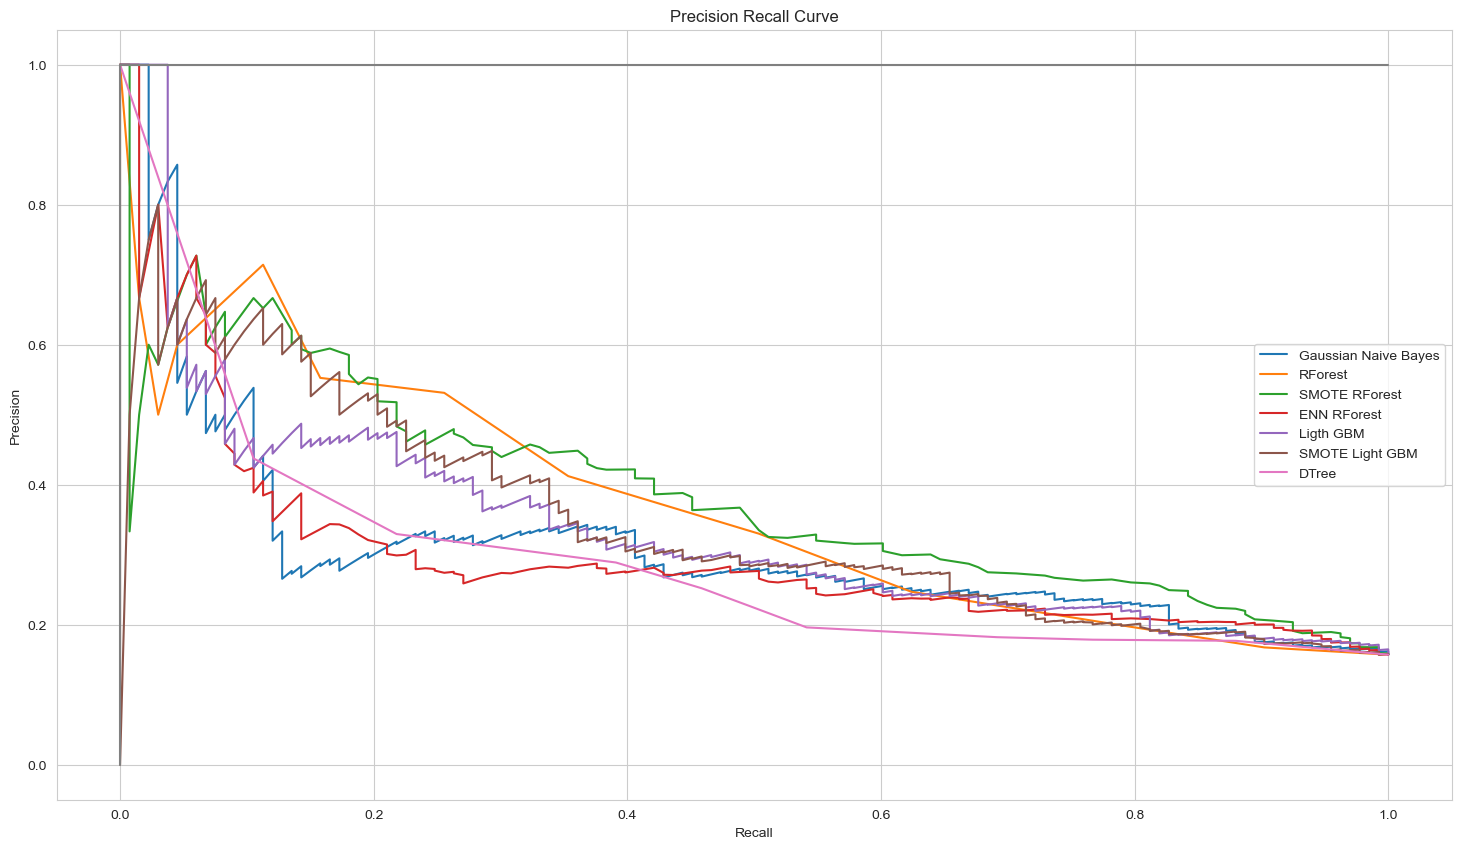

In [11]:
# Generación métricas precision, recall 
GNB_precision , GNB_recall , GNB_threshold = precision_recall_curve(y_test ,predsdmodel_gau)
rforest_precision , rforest_recall , rforest_threshold = precision_recall_curve(y_test , predsdmodel_rforest)
SMOTErforest_precision , SMOTErforest_recall ,SMOTErforest_threshold = precision_recall_curve(y_test , predsdmodel_Srforest )
ENNrforest_precision , ENNrforest_recall ,ENNrforest_threshold = precision_recall_curve(y_test , predsdmodel_ENNrforest)
lgbm_precision , lgbm_recall , lgbm_threshold = precision_recall_curve(y_test , predsdmodel_lgbm)
Slgbm_precision ,Slgbm_recall , Slgbm_threshold = precision_recall_curve(y_test , predsdmodel_SMOTElgbm)
dtree_precision ,dtree_recall ,dtree_threshold = precision_recall_curve(y_test , predsdmodel_dtree)



# Gráfico curva precision recall curve
sns.set_style('whitegrid')
plt.figure(figsize=(18,10))
plt.title('Precision Recall Curve')

plt.plot(GNB_recall , GNB_precision,label="Gaussian Naive Bayes")
plt.plot(rforest_recall , rforest_precision,label="RForest")
plt.plot(SMOTErforest_recall , SMOTErforest_precision ,label="SMOTE RForest")
plt.plot(ENNrforest_recall , ENNrforest_precision,label="ENN RForest")
plt.plot(lgbm_recall , lgbm_precision ,label="Ligth GBM")
plt.plot(Slgbm_recall , Slgbm_precision,label="SMOTE Light GBM")
plt.plot(dtree_recall , dtree_precision ,label="DTree")



plt.plot([0,0],[1,0],c='.5')
plt.plot([1,1],c='.5')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.legend()
plt.show()

***
<a id="3"></a> <br>
## 3. Conclusiones y elección de modelo

<a id="31"></a> <br>
### 3.1. Conclusiones y eleccion de modelo

***
<a id="4"></a> <br>
## 4. Predicción con mejor modelo

<a id="41"></a> <br>
### 4.1. Prediccion con modelo elegido

In [12]:
pred = pd.DataFrame(model_pred_test_ENN_rforest, columns=["Attrition"])
pred.index = X_test.index
pred

,Attrition
1915,1
1401,1
208,0
1493,1
2175,1
...,...
3260,0
317,1
1909,0
2633,0


In [13]:
df_pred = pd.concat([X_test.iloc[:, :2], pred, X_test.iloc[:, 2:]], axis=1)
df_pred

,EmployeeID,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Employee Source,AgeStartedWorking
1915,3774,25,1,Travel_Rarely,Research & Development,4,Below college,Technical Degree,4,Male,...,1,7,3,4,7,7,5,6,Recruit.net,18
1401,1196,47,1,Travel_Frequently,Sales,27,College,Life Sciences,2,Female,...,0,8,2,3,5,4,1,3,Indeed,39
208,7738,38,0,Travel_Frequently,Research & Development,23,Bachelor,Life Sciences,1,Male,...,1,8,4,3,2,2,2,0,Recruit.net,30
1493,5829,27,1,Travel_Rarely,Research & Development,5,Below college,Technical Degree,3,Male,...,1,9,3,3,9,8,0,8,Adzuna,18
2175,8612,34,1,Travel_Rarely,Sales,2,Bachelor,Marketing,3,Female,...,0,4,3,3,3,2,0,2,GlassDoor,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3260,9633,47,0,Travel_Rarely,Research & Development,25,Bachelor,Medical,1,Male,...,0,25,3,3,17,14,12,11,Jora,22
317,3884,34,1,Travel_Rarely,Research & Development,6,Master,Life Sciences,1,Male,...,0,17,3,4,0,0,0,0,Referral,17
1909,1699,59,0,Travel_Rarely,Research & Development,3,Bachelor,Medical,3,Male,...,1,4,5,2,4,2,2,2,Seek,55
2633,9898,47,0,Travel_Rarely,Sales,14,Bachelor,Medical,4,Male,...,1,27,2,3,1,0,0,0,Company Website,20


<a id="42"></a> <br>
### 4.2. Exportar predicciones en CSV